In [95]:
import pandas as pd
pd.set_option('display.max_columns', 1000)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from dateutil import parser
from datetime import datetime

In [96]:
"""
What factors can potentially impact the transporter time?
1. Lane/ route
2. Category
3. po_qty?

"""

'\nWhat factors can potentially impact the transporter time?\n1. Lane/ route\n2. Category\n3. po_qty?\n\n'

In [97]:
df1 = pd.read_excel('l2_data.xlsx', 'L2 raw data')
df2 = pd.read_excel('l2_data.xlsx', 'PO level')
df2 = df2[df2['order_status'].str.lower() == 'completed']
# df2 = df2[['buyer_name', 'seller_name', 'seller_po_number', 'seller_po_status', 'transporter_type' , 'seller_po_creation_date', 'buyer_invoice_item_quantity', 'po_quantity', 'order_completion_percentage', 'o2d_']]
df1.head()

,sno,po_number,po_qty,seller_po_creation_date,category,dispatched_qty,origin,destination,dispatch_week,po_ts,nextbuy_order_indent_ts,nextbuy_vehicle_indent_ts,transporter_order_indent_ts,transporter_order_indent_acceptance_ts,vehicle_placement_ts,expected_date_of_vehicle_reporting,vehicle_reported_ts,vehicle_loaded_ts,vehicle_dispatched_ts,vehicle_reached_delivery_location_ts,payment_confirmation_received_by_ops,vehicle_unloaded_ts,nextbuy_order_indent_tat,nextbuy_vehicle_indent_tat,vehicle_placement_tat,vehicle_reported_tat,vehicle_dispatch_tat,vehicle_reported_actual_vs_expected,transporter_order_tat,vehicle_level_o2d,vehicle_level_o2dqty,O2D_
0,1,PO/25/MH/96,60.0,2024-04-12 13:50:32.410,RMC - Aluminium,29.709999,Raipur,Gandhinagar,April 2 Week,04-12-2024 19:20:32,4/12/2024 20:07:00,4/12/2024 20:07:00,4/12/2024 20:12:00,4/12/2024 20:45:00,4/13/2024 11:52:00,4/13/2024 23:59:59,4/13/2024 12:51:00,4/13/2024 15:57:00,4/13/2024 18:02:00,4/16/2024 9:55:00,4/16/2024 10:15:00,4/16/2024 13:30:00,0.032280,0.000012,0.656262,0.040984,0.215984,-0.464583,0.003484,0.945463,28.085899,0.945335
1,2,PO/25/MH/73,300.0,2024-04-10 13:23:40.897,RMC - Steel,39.230000,Raipur,Jalna,April 3 Week,04/10/2024 18:53:40,4/12/2024 20:40:00,4/12/2024 20:40:00,4/12/2024 20:55:00,4/12/2024 21:40:00,4/13/2024 18:22:00,4/14/2024 23:59:59,4/14/2024 7:26:00,4/15/2024 14:10:00,4/15/2024 15:32:00,4/18/2024 9:00:00,4/18/2024 10:12:00,4/19/2024 10:45:00,2.073854,0.000012,0.904178,0.544456,1.337512,-0.690278,0.010428,4.859950,190.656006,4.859954
2,3,PO/25/MH/73,300.0,2024-04-10 13:23:40.897,RMC - Steel,34.189999,Raipur,Jalna,April 3 Week,04/10/2024 18:53:40,4/12/2024 20:40:00,4/12/2024 20:40:00,4/12/2024 20:55:00,4/12/2024 21:40:00,4/13/2024 18:22:00,4/14/2024 23:59:59,4/14/2024 7:26:00,4/15/2024 16:37:00,4/15/2024 17:20:00,4/18/2024 12:00:00,4/18/2024 12:00:00,4/19/2024 11:30:00,2.073854,0.000012,0.904178,0.544456,1.412512,-0.690278,0.010428,4.934950,168.725998,4.934952
3,4,PO/25/MH/96,60.0,2024-04-12 13:50:32.410,RMC - Aluminium,29.260000,Raipur,Gandhinagar,April 3 Week,04-12-2024 19:20:32,4/12/2024 20:07:00,4/14/2024 21:50:00,4/12/2024 20:12:00,4/12/2024 20:45:00,4/15/2024 11:55:00,4/15/2024 23:59:59,4/15/2024 13:30:00,4/15/2024 17:55:00,4/15/2024 19:30:00,4/17/2024 20:00:00,4/18/2024 15:20:00,4/18/2024 16:30:00,0.032280,2.071539,0.586817,0.065984,0.250012,-0.437500,0.003484,3.006570,87.966301,3.006367
4,5,PO/25/HA/111,600.0,2024-04-16 12:24:35.313,RMC - Steel,25.129999,Durgapur,Sikendarabad,April 3 Week,04/16/2024 17:54:35,4/17/2024 16:23:00,4/17/2024 16:23:00,4/18/2024 10:20:00,4/18/2024 10:50:00,4/22/2024 11:00:00,4/19/2024 23:59:59,04/24/24 4:05:00,04/24/24 14:02:00,04/24/2024 22:15:00,4/26/2024 23:00:00,04/27/2024 16:15:00,04/28/2024 15:00:00,0.936412,0.000012,4.775706,1.711817,0.756956,4.170139,0.747928,8.180850,205.585007,8.180860


In [98]:
df = df1.merge(df2, left_on='po_number', right_on = 'seller_po_number', how = 'left')

# df['vehicle_unloaded_ts'] = pd.to_datetime(df['vehicle_unloaded_ts'], format='%m/%d/%y %H:%M:%S')
df = df.sort_values(by=['po_number', 'vehicle_unloaded_ts'])

## Renaming the category
df.loc[(df['category'] == 'RMX - Steel'), 'category'] = 'RMC - Steel'

## Ranking the order of the transport
df['order'] = df.groupby('po_number')[['vehicle_reached_delivery_location_ts']].rank(method='first')

## Route
df['route'] = df['origin'].str.lower() + '-' + df['destination'].str.lower()

### Month wise
df['po_ts'] = df['po_ts'].astype(str)
def safe_parse(date_str):
    try:
        return parser.parse(date_str)
    except (ValueError, TypeError):
        return pd.NaT

df['po_ts'] = df['po_ts'].apply(safe_parse)
df['Month'] = df['po_ts'].dt.strftime('%B')


### Total rounds 

po_count = df['po_number'].value_counts().reset_index()
po_count.rename(columns = {'count' : 'total_rounds'}, inplace = True)
df = df.merge(po_count, on = 'po_number')

print(df.shape)

(89, 52)


In [99]:
def convert_date_format(date_str):
    if pd.isna(date_str):
        return np.nan
    
    if isinstance(date_str, pd.Timestamp):
        return date_str.strftime("%m/%d/%Y %H:%M:%S")
    
    if isinstance(date_str, str):
        # Add seconds if not present in the input string
        if len(date_str.split(':')) == 2:
            date_str += ":00"
        
        # Try different possible input formats for string inputs
        for fmt in ("%m/%d/%y %H:%M:%S", "%m/%d/%Y %H:%M:%S"):
            try:
                dt = datetime.strptime(date_str, fmt)
                return dt.strftime("%m/%d/%Y %H:%M:%S")
            except ValueError:
                pass
        
        # Handle formats with a single-digit month or day
        try:
            dt = datetime.strptime(date_str, "%m/%d/%Y %H:%M:%S")
            return dt.strftime("%m/%d/%Y %H:%M:%S")
        except ValueError:
            pass
        
    raise ValueError(f"Date format not recognized for '{date_str}'")

# Assuming df is already defined
df['nextbuy_vehicle_indent_ts'] = df['nextbuy_vehicle_indent_ts'].apply(lambda x: convert_date_format(x))
df['vehicle_placement_ts'] = df['vehicle_placement_ts'].apply(lambda x: convert_date_format(x))
df['vehicle_unloaded_ts'] = df['vehicle_unloaded_ts'].apply(lambda x: convert_date_format(x))
df['vehicle_reported_ts'] = df['vehicle_reported_ts'].apply(lambda x: convert_date_format(x))
df['vehicle_dispatched_ts'] = df['vehicle_dispatched_ts'].apply(lambda x: convert_date_format(x))
df['vehicle_reached_delivery_location_ts'] = df['vehicle_reached_delivery_location_ts'].apply(lambda x: convert_date_format(x))


df3 = df[['po_number', 'po_qty', 'po_ts', 'category', 'dispatched_qty', 'origin', 'destination', 'O2D_', 
          'nextbuy_vehicle_indent_ts', 'vehicle_reported_ts', 'vehicle_placement_ts',
          'transporter_order_indent_ts', 'transporter_order_indent_acceptance_ts', 'buyer_name', 'seller_name', 
          'Tons_Bucket', 'order', 'route', 'Month', 'total_rounds']]

df3['transporter_time'] = (pd.to_datetime(df3['vehicle_placement_ts']) - pd.to_datetime(df3['nextbuy_vehicle_indent_ts'])).dt.total_seconds() / (3600 * 24)
df3['transporter_indent_to_accept_tat'] = (pd.to_datetime(df3['transporter_order_indent_acceptance_ts']) - pd.to_datetime(df3['transporter_order_indent_ts'])).dt.total_seconds() / (3600 * 24)
df3['transporter_accept_to_placement_tat'] = (pd.to_datetime(df3['vehicle_reported_ts']) - pd.to_datetime(df3['transporter_order_indent_acceptance_ts'])).dt.total_seconds() / (3600 * 24)



### Encoding the Lane to identify the pattern(if any):

df3 = pd.get_dummies(df3, columns=['route'], prefix='route')
df3 = df3_encoded.replace({True: 1, False: 0})
# df3 = pd.concat([df3, df3_encoded], axis=1)

/tmp/ipykernel_87804/653084899.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['transporter_time'] = (pd.to_datetime(df3['vehicle_placement_ts']) - pd.to_datetime(df3['nextbuy_vehicle_indent_ts'])).dt.total_seconds() / (3600 * 24)
/tmp/ipykernel_87804/653084899.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['transporter_indent_to_accept_tat'] = (pd.to_datetime(df3['transporter_order_indent_acceptance_ts']) - pd.to_datetime(df3['transporter_order_indent_ts'])).dt.total_seconds() / (3600 * 

In [100]:
df3.head()

,po_number,po_qty,po_ts,category,dispatched_qty,origin,destination,O2D_,nextbuy_vehicle_indent_ts,vehicle_reported_ts,vehicle_placement_ts,transporter_order_indent_ts,transporter_order_indent_acceptance_ts,buyer_name,seller_name,Tons_Bucket,order,Month,total_rounds,transporter_time,transporter_indent_to_accept_tat,transporter_accept_to_placement_tat,route_durgapur-jaipur,route_durgapur-raipur - rajasthan,route_durgapur-sikendarabad,route_jaipur-ghaziabad,route_kolkata-jharkhand,route_raipur-gandhinagar,route_raipur-jalna,route_raipur-kheda,route_raipur-varanasi,route_visakhapatnam-kheda,route_visakhapatnam-medak
0,PO/25/HA/111,600.0,2024-04-16 17:54:35,RMC - Steel,30.000000,Durgapur,Sikendarabad,8.170434,04/17/2024 16:23:00,04/24/2024 04:00:00,04/24/2024 07:31:00,4/18/2024 10:20:00,4/18/2024 10:50:00,HANNU STEEL PRIVATE LIMITED,SUMANGAL ISPAT PVT LTD,400+,1.0,April,17,6.630556,0.020833,5.715278,0,0,1,0,0,0,0,0,0,0,0
1,PO/25/HA/111,600.0,2024-04-16 17:54:35,RMC - Steel,25.129999,Durgapur,Sikendarabad,8.180860,04/17/2024 16:23:00,04/24/2024 04:05:00,04/22/2024 11:00:00,4/18/2024 10:20:00,4/18/2024 10:50:00,HANNU STEEL PRIVATE LIMITED,SUMANGAL ISPAT PVT LTD,400+,16.0,April,17,4.775694,0.020833,5.718750,0,0,1,0,0,0,0,0,0,0,0
2,PO/25/HA/111,600.0,2024-04-16 17:54:35,RMC - Steel,42.040001,Durgapur,Sikendarabad,13.128758,04/17/2024 16:23:00,04/29/2024 05:00:00,04/29/2024 09:03:00,4/18/2024 10:20:00,4/18/2024 10:50:00,HANNU STEEL PRIVATE LIMITED,SUMANGAL ISPAT PVT LTD,400+,17.0,April,17,11.694444,0.020833,10.756944,0,0,1,0,0,0,0,0,0,0,0
3,PO/25/HA/111,600.0,2024-04-16 17:54:35,RMC - Steel,41.520000,Durgapur,Sikendarabad,13.170424,04/17/2024 16:23:00,04/29/2024 05:00:00,04/28/2024 22:12:00,4/18/2024 10:20:00,4/18/2024 10:50:00,HANNU STEEL PRIVATE LIMITED,SUMANGAL ISPAT PVT LTD,400+,2.0,April,17,11.242361,0.020833,10.756944,0,0,1,0,0,0,0,0,0,0,0
4,PO/25/HA/111,600.0,2024-04-16 17:54:35,RMC - Steel,33.790001,Durgapur,Sikendarabad,11.170435,04/17/2024 16:23:00,04/27/2024 05:30:00,04/26/2024 15:00:00,4/18/2024 10:20:00,4/18/2024 10:50:00,HANNU STEEL PRIVATE LIMITED,SUMANGAL ISPAT PVT LTD,400+,3.0,April,17,8.942361,0.020833,8.777778,0,0,1,0,0,0,0,0,0,0,0


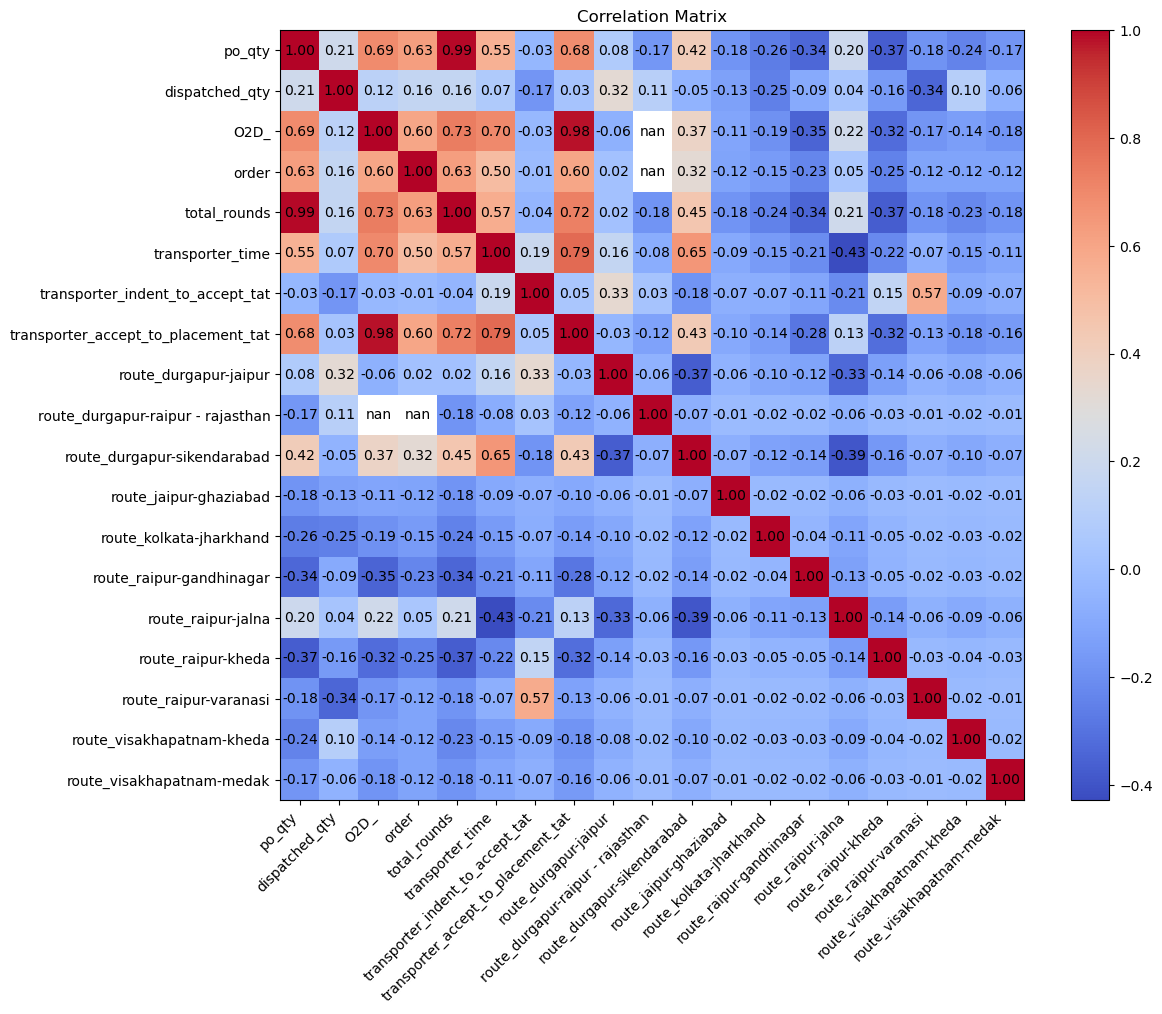

In [106]:
numeric_cols = df3.select_dtypes(include=['number']).columns

# Calculate the correlation matrix
correlation_matrix = df3[numeric_cols].corr()

# Plotting the heatmap with correlation values
plt.figure(figsize=(12, 10))
heatmap = plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')

# Adding color bar
plt.colorbar(heatmap)

# Adding labels
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)

# Adding correlation values
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.title('Correlation Matrix')
plt.show()

## Transporter Level : 
Metric : Vehicle Indent to Vehicle Placement

### Transporter time is impacted by : 
1. trasporter accept to vehicle placement TAT : 0.79
2. When the route is durgapur-sikandarabad : 0.65
3. When route is raipur - Jalna  :-0.43

### Vehicle Accept to placement has a very high correlation with O2D
### Vehicle indent to accept is high when the route is raipur to varanasi.



In [ ]:
Q. Can we control the Vehicle indent to acceptance?